# **Spam Filter using Bayesian Networks**

### The aim of this project is to build a spam filter using Naive Bayes algorithm from scratch. Leveraging the Bayes theorem the model is built to predict the probability that a given text is spam or non-spam based on the training data exposed to the model.

## Importing necessary libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import chain
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from PIL import Image 
import kaggle as kg
import os

## Downloading the dataset from Kaggle

In [4]:
os.environ["KAGGLE_USERNAME"] = "nipunkul2001"
os.environ["KAGGLE_KEY"] = "31e0809f647ecccaae04d69d96bbe6e2"

In [5]:
kg.api.authenticate()


In [6]:
kg.api.dataset_download_files(dataset="uciml/sms-spam-collection-dataset",
                              path="dataset",unzip=True)

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset


In [8]:
df = pd.read_csv("dataset/spam.csv",encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Exploring the dataset

#### -finding and removing null values
#### - dropping unnecessary columns
#### - Visualizing the data

In [9]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [10]:
df.shape

(5572, 5)

In [11]:
df.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [14]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],inplace=True,axis=1)

In [15]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
df.shape

(5572, 2)

In [19]:
df.columns= ['Labels','SMS']

In [20]:
df.head()

,Labels,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


##### The proportion of spam to proportion of ham (non-spam) is important for the classifier. A countplot perfectly captures this statistic.

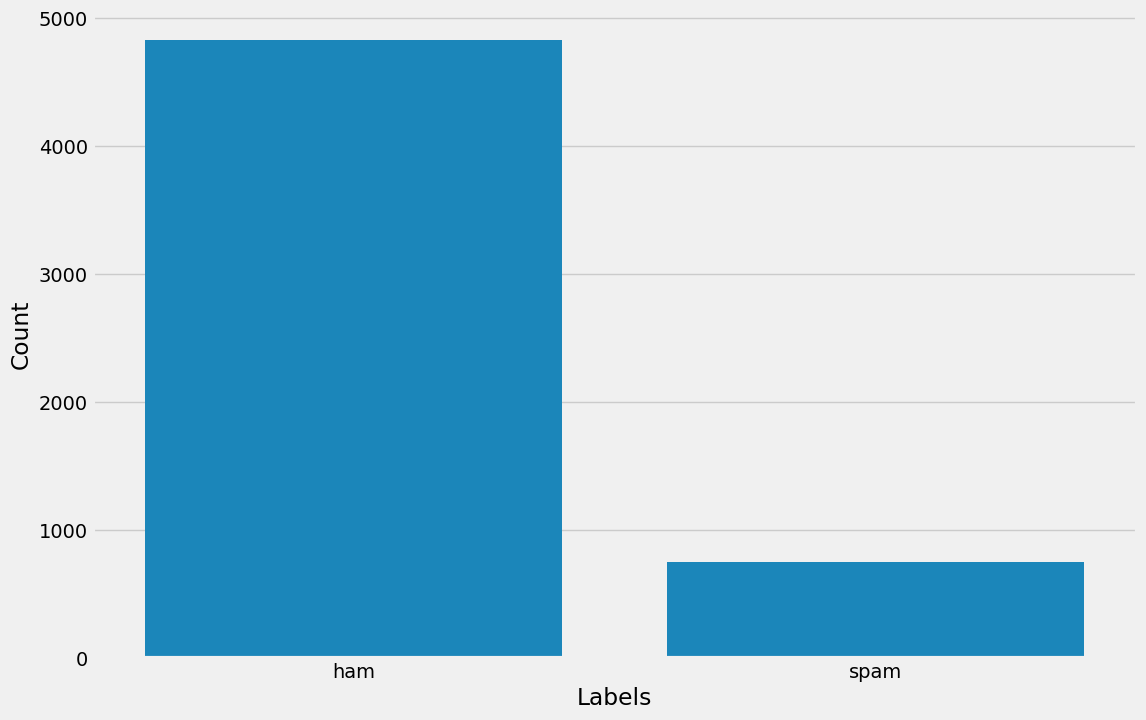

Labels
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64


In [26]:
plt.figure(figsize=(12,8))

# Use the fivethirtyeight style
plt.style.use('fivethirtyeight')

# Create a countplot with vertical bars
sns.countplot(x='Labels', data=df)

# Customize the plot
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-ticks if necessary

# Show the plot
plt.show()

# Print the normalized value counts
print(df['Labels'].value_counts(normalize=True))

#### **Observation**

##### The dataset is highly imbalanced i.e. the target variable doesnot have equal proportions of its classes. There are multiple ways to solve this problem.Since the classifier is a probabilistic model, probability is relative and hence will make up for the imbalance.

##### The dataset here is split into 80:20. The train data will be 80% and test data 20% of the entire population. All randomly selected. The sampling is done using the sample function of pandas

In [27]:
randomized = df.sample(frac=1,random_state=1)
train_size = round(len(randomized) * 0.8)
train = randomized[:train_size].reset_index(drop=True)
test = randomized[train_size:].reset_index(drop=True)
print(train.shape)
print(test.shape)

(4458, 2)
(1114, 2)


##### A sample of a population has to be a representative of the population, otherwise the results obtained can be faulty or skewed. Thus it becomes very important to check for this criterion before moving forward with the project.

In [29]:
train.Labels.value_counts(normalize=True)


Labels
ham     0.864065
spam    0.135935
Name: proportion, dtype: float64

In [30]:
test.Labels.value_counts(normalize=True)

Labels
ham     0.873429
spam    0.126571
Name: proportion, dtype: float64

##### Comparing the splits, the proportion of classes for the two splits as well as the entire population (found above) are very near to eachother. This is a good enough measure to prove that the split samples are good representatives of the population for this dataset.The above logic pushes for cleaning the text to only recover the terms that are useful and remove stopwords, punctuations and anything extra in the texts.

In [31]:
train.SMS.head(10)


0                             Convey my regards to him
1             [Û_] anyway, many good evenings to u! s
2    My sort code is  and acc no is . The bank is n...
3                          Sorry i din lock my keypad.
4    Hi babe its Chloe, how r u? I was smashed on s...
5    Ok i thk i got it. Then u wan me 2 come now or...
6                               Oi when you gonna ring
7    Will be office around 4 pm. Now i am going hos...
8    Have you heard about that job? I'm going to th...
9                           Oh my God. I'm almost home
Name: SMS, dtype: object

In [32]:
train.SMS = train['SMS'].str.replace('\W',' ')
train.SMS = train['SMS'].str.lower()
train.SMS.head(10)

0                             convey my regards to him
1             [û_] anyway, many good evenings to u! s
2    my sort code is  and acc no is . the bank is n...
3                          sorry i din lock my keypad.
4    hi babe its chloe, how r u? i was smashed on s...
5    ok i thk i got it. then u wan me 2 come now or...
6                               oi when you gonna ring
7    will be office around 4 pm. now i am going hos...
8    have you heard about that job? i'm going to th...
9                           oh my god. i'm almost home
Name: SMS, dtype: object

In [33]:
messages = train.SMS.str.split()
words = list(chain(*messages))
vocabulary = pd.Series(words).unique()
len(vocabulary)

11768

#### In the train set, there are 11768 unique words for our vocabulary. These have been retrieved from the messages.Using the vocabulary, the Term Document Matrix is derived. For the ease of usage, a dictionary representing the same concept is made.

In [34]:
no_of_messages = len(train.SMS)
word_counts = {word: [0] * no_of_messages for word in vocabulary}

for index,mssge in enumerate(messages):
    for word in mssge:
        word_counts[word][index] += 1

#### The above method made a dictionary with every term in the vocabulary as key and for each term a vector identifying in which messages the term appears in and how many times, analogous to the Term Document Matrix

#### The method afore-mentioned is a way of doing this from scratch, that doesnt take into account the stop words. This can also be achieved via the CountVectorizer function in the sklearn.feature_extraction.text module. Here the removal of stopwords is also considered.

In [37]:
token = RegexpTokenizer(r'[a-z0-9A-Z]+')
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1,1),
    tokenizer=token.tokenize
)
counts = vectorizer.fit_transform(train['SMS'])

# Use get_feature_names_out() instead of get_feature_names()
print(len(vectorizer.get_feature_names_out()))
vocabulary = vectorizer.get_feature_names_out()

# Create a dictionary of word counts
word_counts = dict(zip(vocabulary, np.transpose(counts.toarray())))


7450


#### The vocabulary contains 7450 terms after removing the stopwords as well. Since the vocabulary is quite long, it makes it impossible to draw inferences from. One solution is to create a WordCloud to get a gist of the data. The WordClouds will be different for the spam messages and the ham (non-spam) messages. This would give a sense of the kind of words present in both the type of messages.

In [45]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kulnipun/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

The WordCloud function creates an image object, which is viewed using the imshow() function of matplotlib. The width, height and other parameters are set in the wordcloud object. There is a provision for removing stopwords as well in the object. The stopwords paramter has to be supplied with the STOPWORDS object from the nltk.corpus.

The first WordCloud is of the text messages, labeled as spam.

(np.float64(-0.5), np.float64(1199.5), np.float64(799.5), np.float64(-0.5))

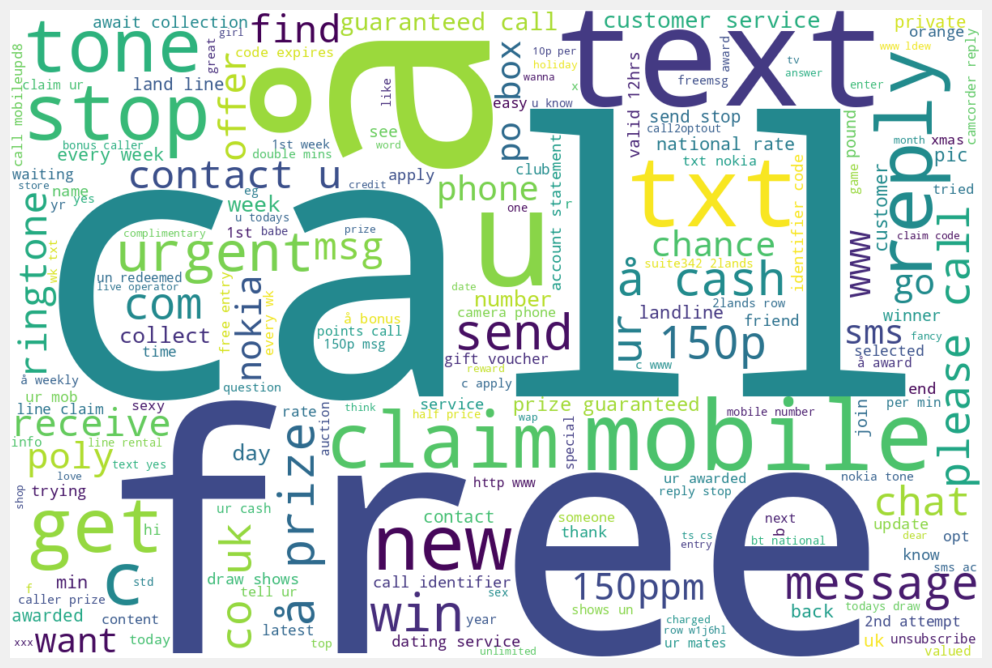

In [46]:
text = ""

for message in train[train.Labels == 'spam'].SMS:
    words = message.split()
    text = text + " ".join(words) + " "
    
# stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=800,stopwords=stopwords.words('english'),background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')


From the WordCloud the words like - free, call, now, txt, tone, reply, mobile, text are frequently appearing words in the spam messages of the training set. This is very intuitive as infact these sort of words do appear in spam messages recieved generally.

The next word cloud is for the ham (non-spam) label.

(np.float64(-0.5), np.float64(1199.5), np.float64(799.5), np.float64(-0.5))

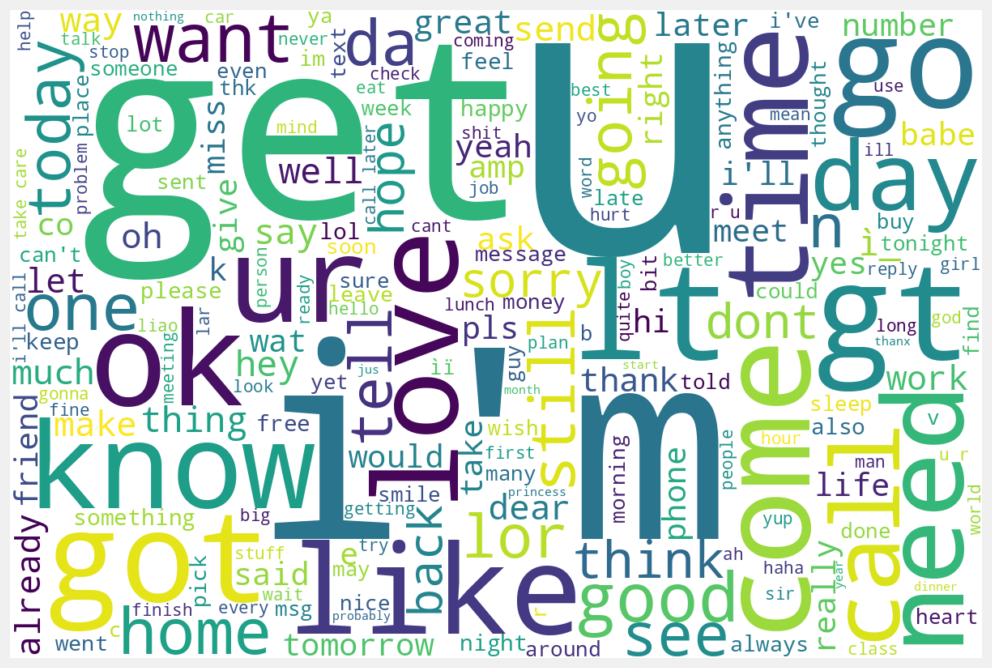

In [48]:
text = ""

for message in train[train.Labels == 'ham'].SMS:
    words = message.split()
    text = text + " ".join(words) + " "
    
# stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=800,stopwords=stopwords.words('english'),background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

There are distinct differences in the variety and kind of words appearing for both the classes/labels. The words appearing in ham(non-spam) messages are generally common words as the WordCloud shows - love, come, know, got, home, need, dear etc. The ones in spam messages convey state very direct actions/objects like the words mentioned.

For model purposes, the dictionary is converted to a DataFrame and appended to the initial dataset. This way the representation for each message becomes easy. Every row is an individual text and every column after the SMS and Label columns represents a word from the vocabulary.

In [49]:
vector_space = pd.DataFrame(word_counts)
train = pd.concat([train,vector_space],axis=1)
train.head(3)

,Labels,SMS,0,00,000,000pes,008704050406,0089,01223585236,01223585334,...,zaher,zealand,zebra,zed,zeros,zhong,zindgi,zoe,zoom,zyada
0,ham,convey my regards to him,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[û_] anyway, many good evenings to u! s",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,my sort code is and acc no is . the bank is n...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Before the model building starts, the stopwords have to be removed from the SMS columns permanently. The stopwords are usually present in all messages and are not relevant when distinguishing between spam and ham (non-spam) messages.

The train dataset is ready for model building. The Naive Bayes algorithm's formula requires the following terms. Precalculating them once saves time during model training, :-

P(spam) - probability of spam

P(ham) - probability of non-spam

Nspam - number of words in spam messages

Nham - number of words in non-spam messages

Nvocab - number of words in vocabulary

Alpha - Laplace smoothing constant

In [51]:
alpha = 1
P_spam = train.Labels.value_counts(normalize=True)['spam']
P_ham = train.Labels.value_counts(normalize=True)['ham']
N_spam = len(list(chain(*messages[train.Labels == 'spam'])))
N_ham = len(list(chain(*messages[train.Labels == 'ham'])))
N_vocab = len(vocabulary)

The paramters

- P(wi|spam)

- P(wi|ham)


where wi stands for each word in the vocabulary. These formulas calculate the probability of a word appearing in the text given the message label. These calculations are static like the ones done previously. Hence calculating them once will avoid meaningless calculations during training phaze.

Two separate dictionaries, for spam and ham (non-spam) are maintained, mapping word to its probability of appearing in the respective label.

In [53]:
P_word_given_spam = {word: 0 for word in vocabulary}
P_word_given_ham = {word: 0 for word in vocabulary}

Spam_messages = train[train.Labels == 'spam']
Ham_messages = train[train.Labels == 'ham']

for word in vocabulary:
    
    N_word_given_spam = Spam_messages[word].sum()
    N_word_given_ham = Ham_messages[word].sum()
    
    P_word_given_spam[word] = (
        (N_word_given_spam + alpha) / (N_spam + (alpha * N_vocab))
    )
    
    P_word_given_ham[word] = (
        (N_word_given_ham + alpha) / (N_ham + (alpha * N_vocab))
    )

In [54]:
def classify(message,verbose):
    
    message = re.sub('\W',' ',message)
    message = message.lower()
    message = message.split()
    
    spam = 1
    ham = 1
    
    for word in message:
        if word in P_word_given_spam.keys():
            spam *= P_word_given_spam[word]
        if word in P_word_given_ham.keys():
            ham *= P_word_given_ham[word]
        
    P_spam_given_message = P_spam * spam
    P_ham_given_message = P_ham * ham
    
    if verbose:
        print("P(spam|message) = ",P_spam_given_message)
        print("P(ham|message) = ",P_ham_given_message)
    
    if P_spam_given_message > P_ham_given_message:
        if verbose:
            print('Label: spam')
        return 'spam'
    elif P_spam_given_message < P_ham_given_message:
        if verbose:
            print('Label: ham')    
        return 'ham'
    else:
        if verbose:
            print('Human assistance needed, equal probabilities')
        return 'Not classified'

he function as specified before accepts an input message and classifies it. The verbose parameter is to get printed output at every step of the function. It is useful when debugging or understanding the working.

The function is tested on the following inputs, as a part of preliminary test :-

Spam - 'WINNER!! This is the secret code to unlock the money: C3421.'
Ham (non-spam) - "Sounds good, Tom, then see u there"

In [55]:
classify('WINNER!! This is the secret code to unlock the money: C3421.',verbose=1)

P(spam|message) =  4.551839661432548e-15
P(ham|message) =  3.336855622339028e-17
Label: spam


'spam'

In [56]:
classify('Sounds good, Tom, then see u there',verbose=1)

P(spam|message) =  3.390172247837783e-15
P(ham|message) =  3.9733430830681635e-13
Label: ham


'ham'

In [57]:
test['predicted'] = test.SMS.apply(classify,verbose=0) #try putting verbose >1 and see the output of the model
test.head(5)


,Labels,SMS,predicted
0,ham,S...from the training manual it show there is ...,ham
1,spam,Do you want a new Video phone? 600 anytime any...,spam
2,ham,True. Its easier with her here.,ham
3,ham,Midnight at the earliest,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [58]:
test.predicted.value_counts(normalize=True)


predicted
ham     0.863555
spam    0.136445
Name: proportion, dtype: float64

Out of the entire test sample, the model classified about 85% as ham and about 14% as spam. The model seems to have done pretty well as these proportions are analogous to the sample's proportion of classes. But this doesnt speak for missclassified labels.

To be clearer with respect to the effectiveness of the model, accuracy is a good metric that describes the proportion of correctly classified labels by the model. The accuracy is simply comparision between the Label and the predicted columns divided by the total units in the test sample.

In [60]:
accuracy = sum(test.Labels == test.predicted)/len(test)
accuracy

0.9883303411131059

The model has achieved a phenomenal accuracy of about 98% on the test set. It obviously seems to good to be true, but this is a result of less data points for training, limited variance in the vocabulary of the population.

The accuracy can be calculated on the train set as well.

In [61]:
train['predicted'] = train.SMS.apply(classify,verbose=0)
accuracy = sum(train.Labels == train.predicted)/len(train)
accuracy

0.9883355764917003

In [62]:
train.predicted.value_counts(normalize=True)


predicted
ham     0.855092
spam    0.144908
Name: proportion, dtype: float64

In [64]:
print(classification_report(test.predicted,test.Labels))


              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       962
        spam       0.99      0.92      0.96       152

    accuracy                           0.99      1114
   macro avg       0.99      0.96      0.97      1114
weighted avg       0.99      0.99      0.99      1114



The model manages to get a 99% accuracy on the train set. And an equally good precision and recall.
Since it is not a 100% for either test or train set, certain messages were missclassified. Its good practice to review the missclassified data, as it could be due to erroneous data or uncleaned text in this case.

In [65]:
def clean(message):
    
    message = re.sub('\W',' ',message)
    message = message.lower()
    
    return message

test.SMS = test.SMS.apply(clean)
missclassified = test[test.Labels != test.predicted]
missclassified

,Labels,SMS,predicted
59,ham,finally the match heading towards draw as your...,spam
91,spam,hello we need some posh birds and chaps to us...,ham
122,ham,lmao take a pic and send it to me,spam
153,ham,send me the new number,spam
294,ham,we have sent jd for customer service cum accou...,spam
497,ham,cheers for the message zogtorius iåõve been s...,spam
544,ham,please protect yourself from e threats sib ne...,spam
551,ham,ofcourse i also upload some songs,spam
677,ham,yavnt tried yet and never played original either,spam
709,ham,any chance you might have had with me evaporat...,spam


(np.float64(-0.5), np.float64(1199.5), np.float64(799.5), np.float64(-0.5))

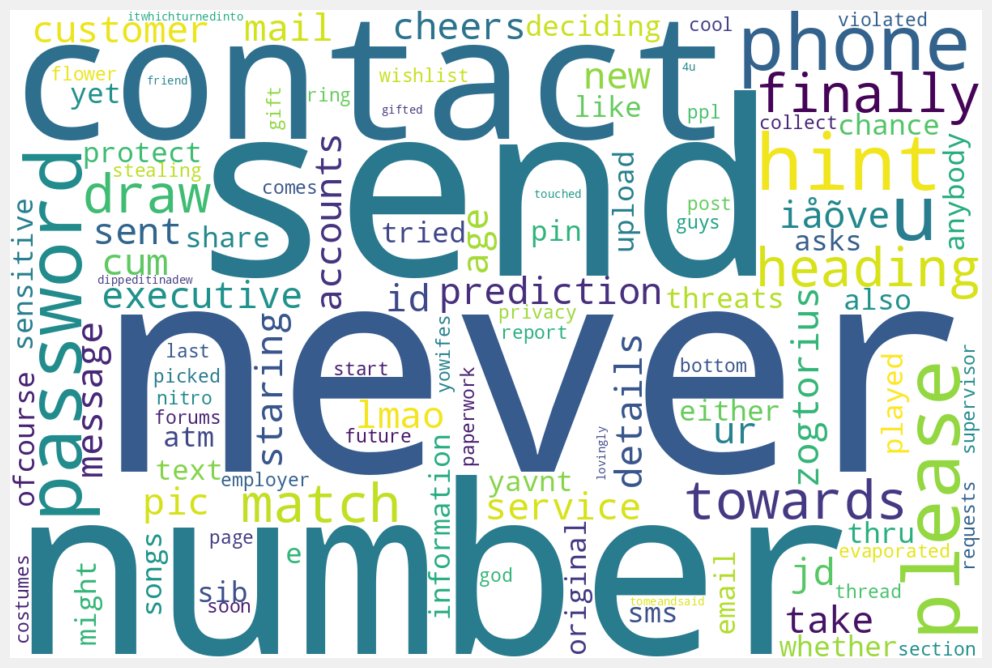

In [66]:
text = ""

for message in missclassified[missclassified.Labels == 'ham'].SMS:
    words = message.split()
    text = text + " ".join(words) + " "
    
# stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=800,stopwords=stopwords.words('english'),background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

(np.float64(-0.5), np.float64(1199.5), np.float64(799.5), np.float64(-0.5))

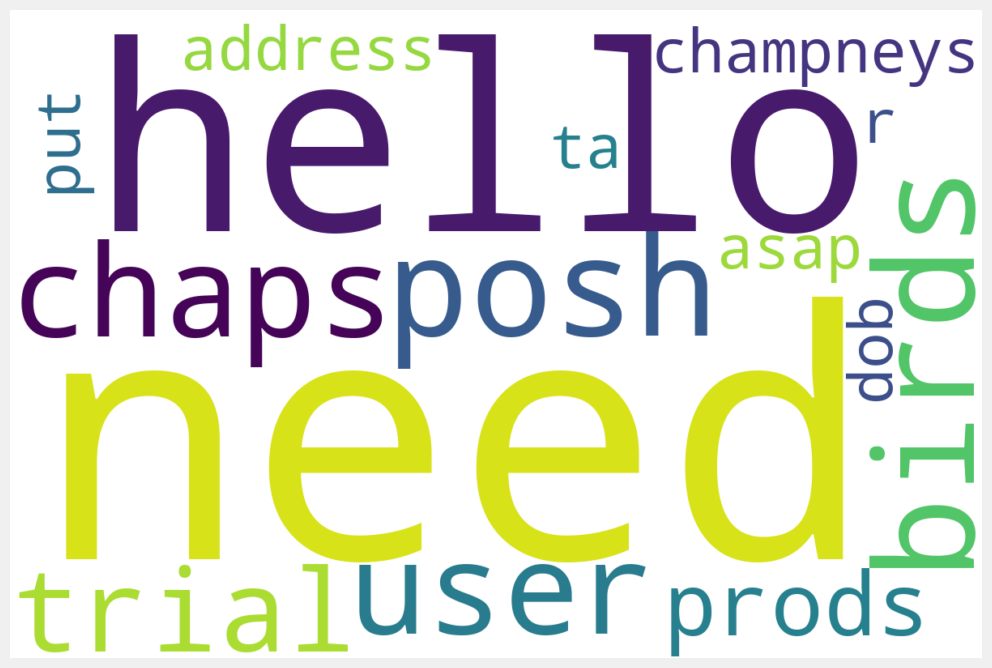

In [68]:
text = ""

for message in missclassified[missclassified.Labels == 'spam'].SMS:
    words = message.split()
    text = text + " ".join(words) + " "
    
# stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=800,stopwords=stopwords.words('english'),background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

# Conclusion

#### In conclusion to the project, a successful model for spam filter was created using the Naive Bayes Algorithm. The model assumes independence between the messages and the words in the messages, oblivious to the context of the message.Just based on this assumption, the model performed very well for this dataset with the following accuracies (approx) :-

- Training accuracy - 98.94%
- esting accuracy - 98.02%

#### The model achieves a good precision and recall scores. However it is important to note that spam messages have a lesser recall. This can be accounted to the fact that there is an imbalance in the classes of the target variable.

#### Overall the model has learnt the training data well and has performed well on the test set for the text messages in the dataset used.